In [6]:
import torch
from google.colab import files
# install the latest release of PyTorch3D
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


# add path for demo utils functions 
import sys
import os

from scipy.spatial import distance
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
# Data structures and functions for rendering
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    SoftSilhouetteShader,
    TexturesVertex
)

!pip install trimesh # install trimesh
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)


!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid


from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
import pytorch3d
import torch
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)
from pytorch3d.io import load_obj
from tqdm import tqdm
from PIL import Image, ImageDraw
from pytorch3d.io import IO

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-07 21:34:43--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.2’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-02-07 21:34:43 (32.3 MB/s) - ‘plot_image_grid.py.2’ saved [1608/1608]



In [14]:
# image generator
def image_gen(renders):
  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images
# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# that function render the pointcloud
def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """ source: https://github.com/learning3d/assignment1/blob/master/starter/utils.py
    Returns a Pytorch3D renderer for point clouds.
    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer

def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.
    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

# ***DISTRIBUTION SCORE***

In [7]:
import numpy as np
from numba import cuda

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1))

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)

    return out


# I generate the point cloud of two different objects

verts, faces, _ = load_obj("/airboat.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("/al.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("/sandal.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Z=np.array(gpu_dist_matrix(point_cloud[0].cpu()))



<ipython-input-8-1173ebf96727>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


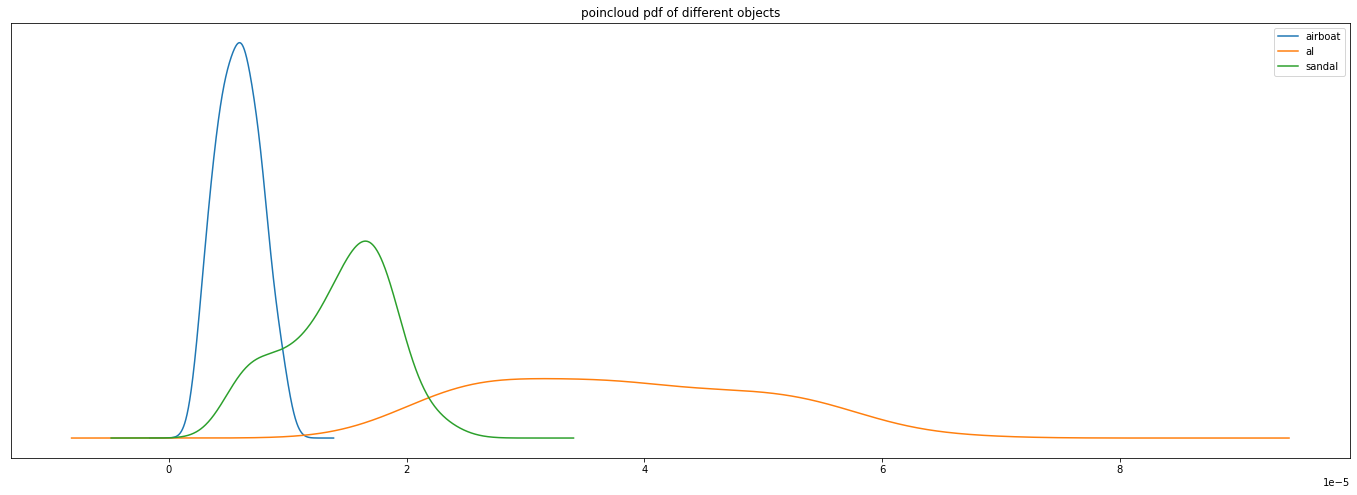

In [8]:
s = pd.DataFrame({
    'airboat': [1/i.sum() for i in X],
    'al': [1/i.sum() for i in Y],
    'sandal': [1/i.sum() for i in Z],
  })

s.plot.kde(bw_method=0.4,figsize=(24,8),title='poincloud pdf of different objects')
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

# ***generate the object with point-e***


In [9]:
!git clone -b multiview https://github.com/halixness/point-e
%cd point-e/

Cloning into 'point-e'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 151 (delta 37), reused 23 (delta 21), pack-reused 91
Receiving objects: 100% (151/151), 6.11 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/point-e


In [10]:
!pip install -e .
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-epdi7swz/clip_dd94a67140ff44c5804ad6c8ffd08d2c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-epdi7swz/clip_dd94a67140ff44c5804ad6c8ffd08d2c
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 

In [11]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler


# setup cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

verts, faces, _ = load_obj("teapot.obj")

mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
# add texture
verts_rgb = torch.abs(torch.sin(torch.stack([torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0]),torch.arange(0,mesh.verts_list()[0].shape[0])],dim=1))).to(device)
verts_rgb = verts_rgb[None,:]
mesh.textures = TexturesVertex(verts_features=verts_rgb) 

--2023-02-07 21:35:23--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘teapot.obj’

teapot.obj          100%[===================>] 149.02K   235KB/s    in 0.6s    

2023-02-07 21:35:25 (235 KB/s) - ‘teapot.obj’ saved [152595/152595]



  0%|          | 0/4 [00:00<?, ?it/s]

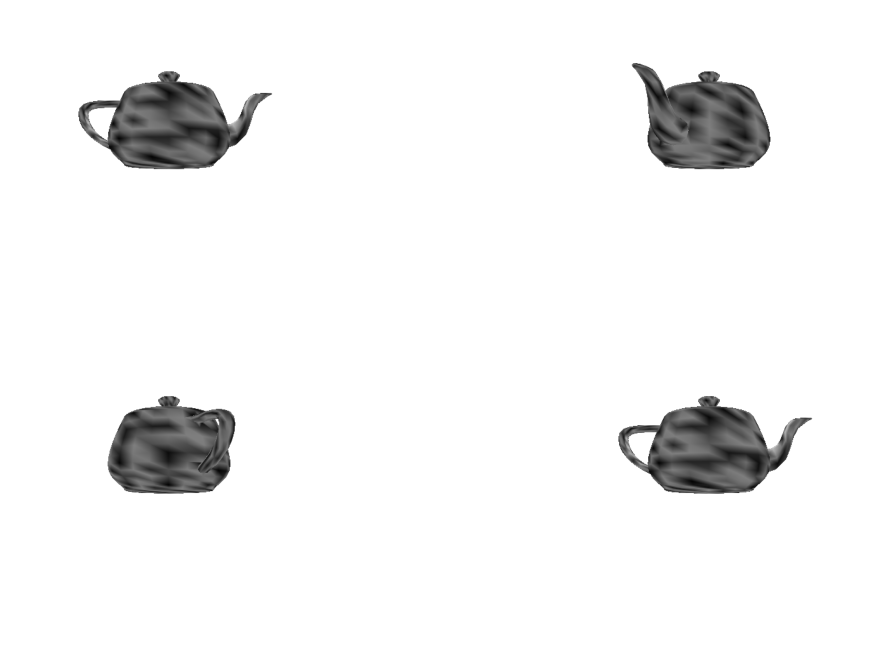

In [15]:
num_img = 4

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=3.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=2, rgb=True)
plt.show()

In [16]:
images=image_gen(renders)

In [17]:
len(images) #number of images

4

**from images to point cloud**

In [18]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [19]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:07<00:00, 125MiB/s]


[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [20]:
num_points = 1024

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [21]:
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=images))):
    samples = x

0it [00:00, ?it/s]

In [22]:
print("size of the point cloud",samples.shape)

size of the point cloud torch.Size([1, 6, 4096])


In [23]:
gen_pointcloud = samples[0, :3, :]
# reshape the point cloud
pc = sampler.output_to_point_clouds(samples)[0]
gen_pointcloud = torch.Tensor(pc.coords)
print('shape: ',gen_pointcloud.shape)

shape:  torch.Size([4096, 3])


In [24]:
original = sample_points_from_meshes(mesh, num_samples=4096).cpu()[0]
original = original.permute(1, 0)
blacks = torch.zeros((3, original.shape[1]))
original = torch.cat((original, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(original)[0]
original = torch.Tensor(pc.coords)

print('shape: ',original.shape)

shape:  torch.Size([4096, 3])


In [25]:
# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(original.cpu()))

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(gen_pointcloud.cpu()))


In [26]:
# This step is important to center the two pointcloud
XX=np.multiply(((Y).max()/(X).max()),X)
#YY=np.multiply(((X).max()/(Y).max()),Y)

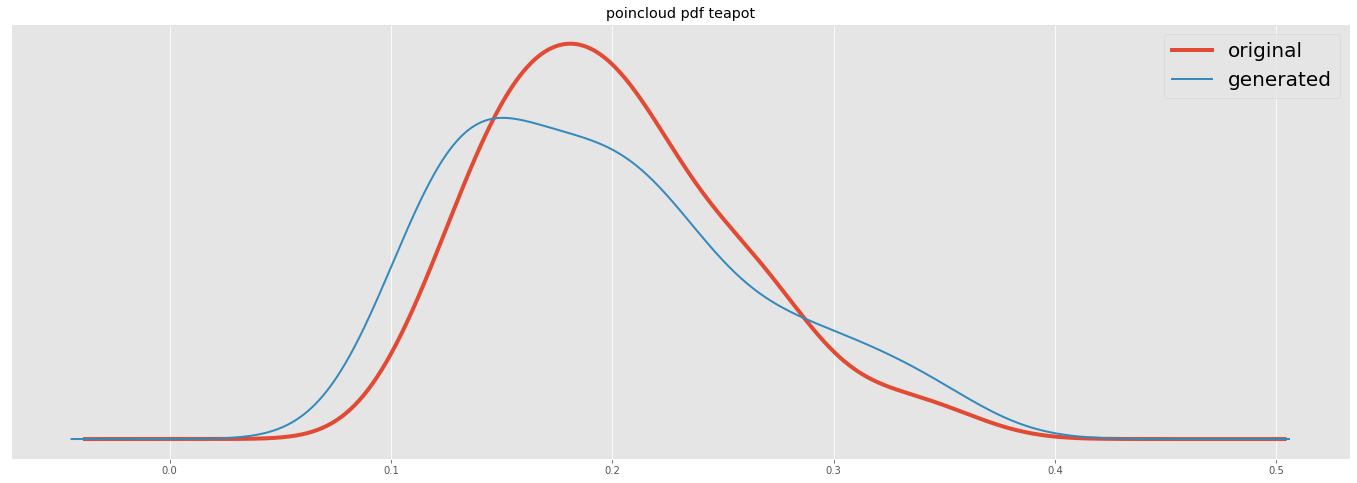

In [27]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

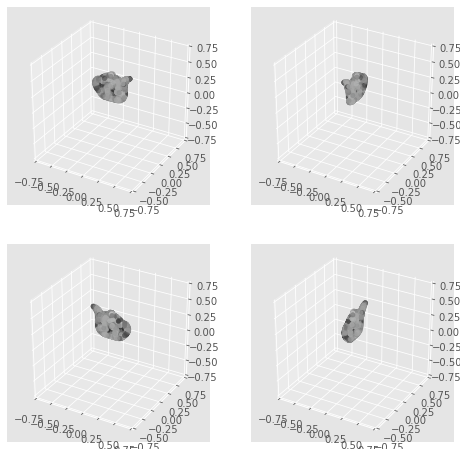

In [28]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Now I try to add different object to check the distributions

In [29]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl

--2023-02-07 21:45:01--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K   361KB/s    in 0.9s    

2023-02-07 21:45:04 (361 KB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-02-07 21:45:04--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[========

In [30]:
v, f, _ = load_obj("data/cow_mesh/cow.obj")

m = Meshes(verts=[v], faces=[f.verts_idx]).to(device)
# add texture
verts_rgb = torch.abs(torch.sin(torch.stack([torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0])],dim=1))).to(device)
verts_rgb = verts_rgb[None,:]
m.textures = TexturesVertex(verts_features=verts_rgb) 

In [31]:
o_new = sample_points_from_meshes(m, num_samples=4096).cpu()[0]
o_new = o_new.permute(1, 0)
blacks = torch.zeros((3, o_new.shape[1]))
o_new = torch.cat((o_new, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(o_new)[0]
o_new = torch.Tensor(pc.coords)

print('shape: ',o_new.shape)

# generate the distance matrix between each pair of variables
O_NEW=np.array(gpu_dist_matrix(o_new.cpu()))

O_NEW = np.multiply(((Y).max()/(O_NEW).max()),O_NEW)

shape:  torch.Size([4096, 3])


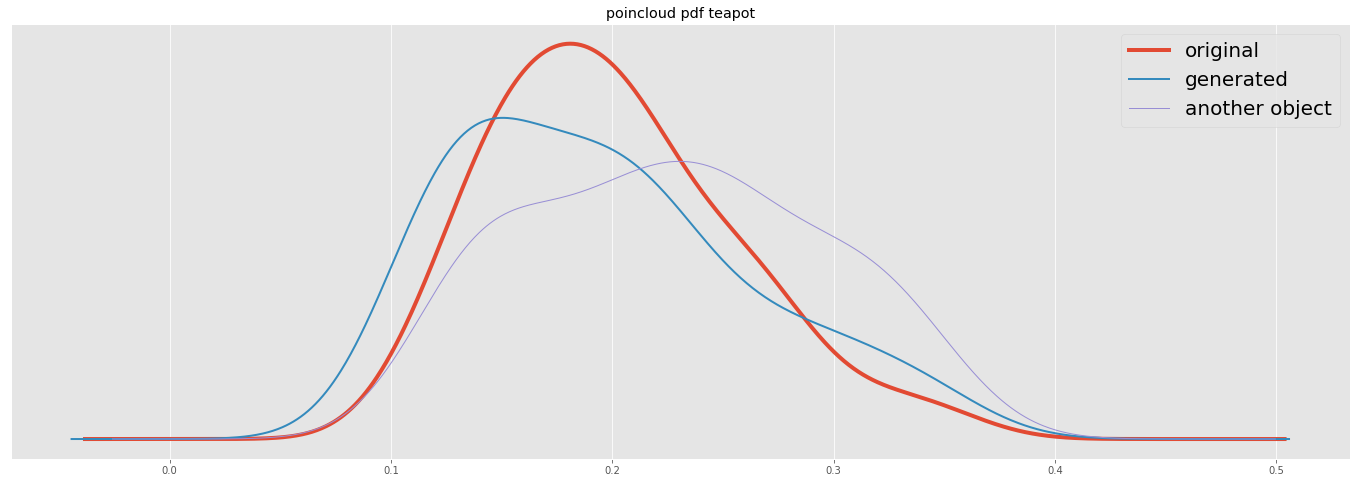

In [32]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
    'another object': [i.max() for i in O_NEW],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
s['another object'].plot.kde(bw_method=0.4,figsize=(24,8),legend="another object",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 1).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

***Chamfer Distance***

Chamfer Distance (CD) is a evaluation metric for two point clouds. It takes the distance of each points into account. For each point in each cloud, CD finds the nearest point in the other point set, and sums the square of distance up. It is utilized in Shapenet's shape reconstruction challenge.



In [33]:
loss_chamfer, _ = chamfer_distance(original.cpu()[None,:], gen_pointcloud.cpu()[None,:])

In [34]:
print('loss chamfer distance: ',loss_chamfer)

loss chamfer distance:  tensor(0.4201)
